In [1]:
import numpy as np
from matplotlib import pyplot as plt
import numba as nb

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [114]:
@nb.njit
def get_euro_put_price(s, u, d, R, T, strike):
    # your code here
    states = np.arange(T + 1)    
    stock_prices = s * (u ** (T - states)) * (d ** states)
    payoff = (strike - stock_prices).clip(0.0)
    option_prices = payoff
    nu = (R - d) / (u - d)
    for t in np.arange(T)[::-1]:
        states = np.arange(t + 1)
        stock_prices = s * (u ** (t - states)) * (d ** states)
        
        option_prices = 1 / R * (nu * option_prices[:-1] + (1 - nu) * option_prices[1:])
    return option_prices[0]

@nb.njit
def get_american_put_price(s, u, d, R, T, strike):
    # your code here
    states = np.arange(T + 1)    
    stock_prices = s * (u ** (T - states)) * (d ** states)
    payoff = (strike - stock_prices).clip(0.0)
    option_prices = payoff
    nu  = (R - d) / (u - d)
    for t in np.arange(T)[::-1]:
        states = np.arange(t + 1)
        cont = 1 / R * (nu * option_prices[:t+1] + (1 - nu) * option_prices[1:t+2])
        stock_prices = s * (u ** (t - states)) * (d ** states)
        option_prices[:t+1] = np.maximum(cont, (strike - stock_prices).clip(0.0))
    return option_prices[0]

In [131]:
s = 40
T = 5000

r = 0.1
sigma = 0.15
u = np.exp(r / T + sigma / np.sqrt(T))
d = np.exp(r / T - sigma / np.sqrt(T))
R = np.exp(r / T)

strikes = s * np.linspace(0.8, 1.2, 50)

In [133]:
prices_euro_put = np.array([get_euro_put_price(s, u, d, R, T, k) for k in strikes])
prices_american_put = np.array([get_american_put_price(s, u, d, R, T, k) for k in strikes])
payoff = (strikes - s).clip(0.0)

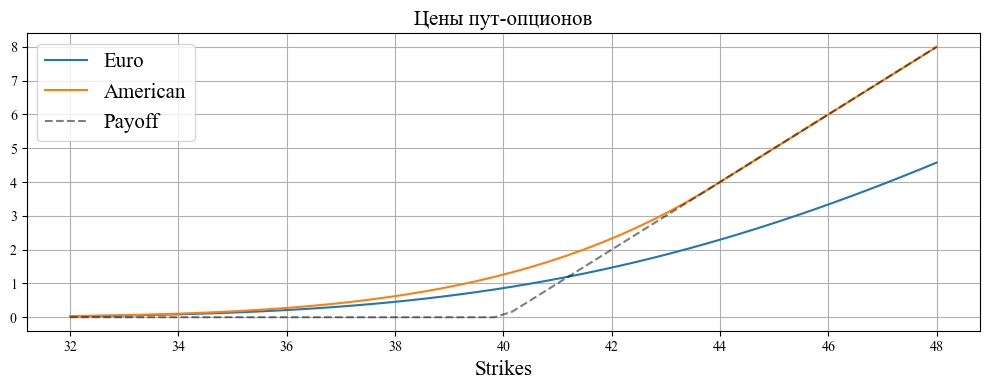

In [134]:
fig = plt.figure(figsize=(10, 4))
plt.title("Цены пут-опционов", fontsize=15)
plt.plot(strikes, prices_euro_put, label='Euro')
plt.plot(strikes, prices_american_put, label='American')
plt.plot(strikes, payoff, '--', color='black', alpha=0.5, label='Payoff')
plt.legend(fontsize=15)
plt.xlabel("Strikes", fontsize=15)
plt.grid()
fig.tight_layout()
fig.savefig("../6_figs/american_euro_prices.jpg")
plt.show()

In [135]:
bump = 1e-1

up = np.array([get_euro_put_price(s + bump, u, d, R, T, k) for k in strikes])
dwn = np.array([get_euro_put_price(s - bump, u, d, R, T, k) for k in strikes])

euro_delta = (up - dwn) / (2 * bump)
euro_gamma = (up - 2 * prices_euro_put + dwn) / (bump ** 2)

up = np.array([get_american_put_price(s + bump, u, d, R, T, k) for k in strikes])
dwn = np.array([get_american_put_price(s - bump, u, d, R, T, k) for k in strikes])

amer_delta = (up - dwn) / (2 * bump)
amer_gamma = (up - 2 * prices_american_put + dwn) / (bump ** 2)

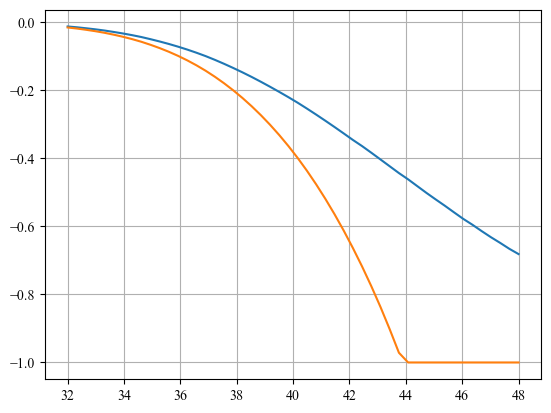

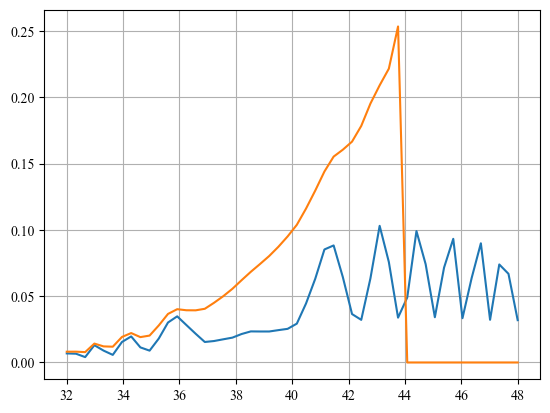

In [136]:
plt.plot(strikes, euro_delta)
plt.plot(strikes, amer_delta)
plt.grid()
plt.show()

plt.plot(strikes, euro_gamma)
plt.plot(strikes, amer_gamma)
plt.grid()
plt.show()

## Perpetual american put

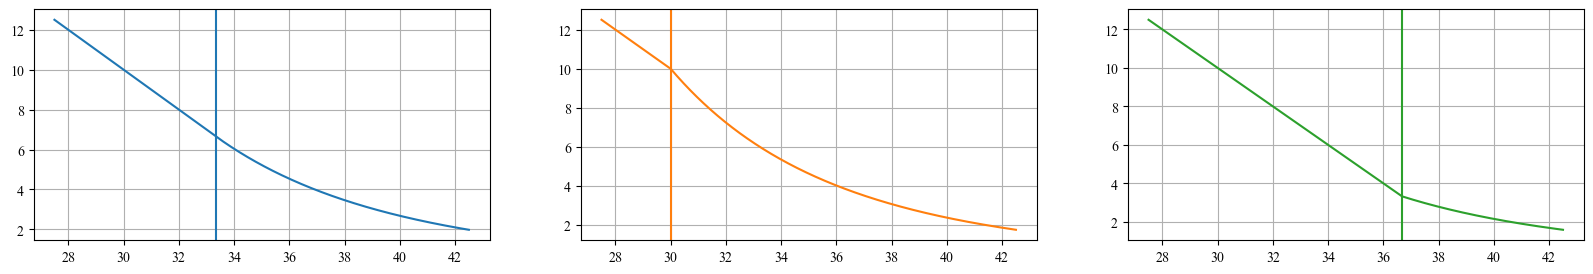

In [109]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

K = 40
s = np.linspace(27.5, 42.5, 1000)
r = 0.1
sigma = 0.2
gamma = -2 * r / sigma ** 2

def get_value(s, L):
    v1 = K - s
    v2 = (K - L) * (s / L) ** (gamma)
    res = np.zeros_like(s)
    res[s < L] = v1[s < L]
    res[s >= L] = v2[s >= L]
    return res

Lstar = 2 * r / (2 * r + sigma ** 2) * K

Llow = Lstar * 0.9
Lhigh = Lstar * 1.1

fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax[0].plot(s, get_value(s, Lstar), color='C0')
ax[0].grid()
ax[0].axvline(Lstar, color='C0')

ax[1].plot(s, get_value(s, Llow), color='C1')
ax[1].grid()
ax[1].axvline(Llow, color='C1')

ax[2].plot(s, get_value(s, Lhigh), color='C2')
ax[2].grid()
ax[2].axvline(Lhigh, color='C2')
plt.show()
#plt.plot(s, get_value(s, Llow), '--', lw=1)
#plt.plot(s, get_value(s, Lhigh), '--', lw=1)

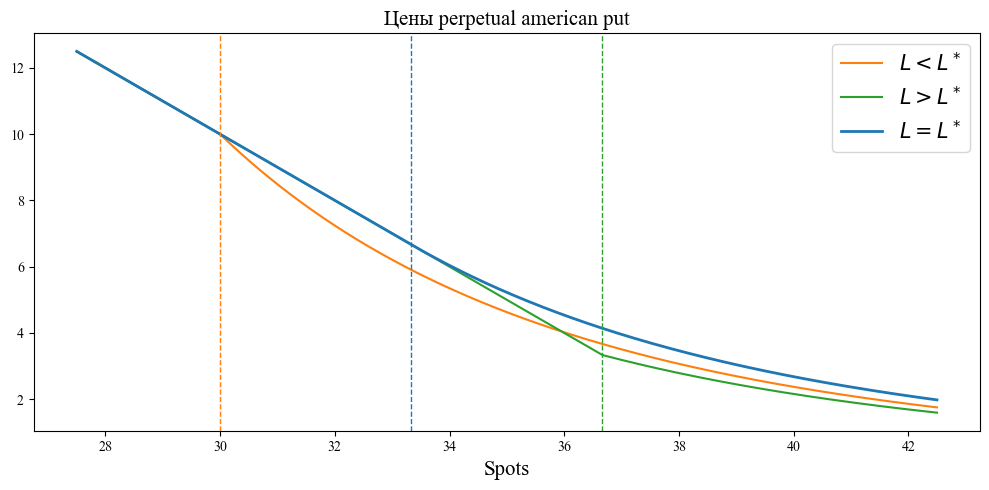

In [114]:
fig = plt.figure(figsize=(10, 5))
plt.title("Цены perpetual american put", fontsize=15)
plt.plot(s, get_value(s, Llow), label=r'$L < L^*$', color='C1')
plt.plot(s, get_value(s, Lhigh), label=r'$L > L^*$', color='C2')
plt.plot(s, get_value(s, Lstar), label=r'$L=L^*$', lw=2, color='C0')
plt.axvline(Lstar, linestyle='--', color='C0', lw=1)
plt.axvline(Llow, linestyle='--', color='C1', lw=1)
plt.axvline(Lhigh, linestyle='--', color='C2', lw=1)
plt.legend(fontsize=15)
plt.xlabel("Spots", fontsize=15)
fig.tight_layout()
plt.show()
fig.savefig('../6_figs/american_perpetual.jpg')